In [18]:
import cdsapi
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Polygon
import collections
import geopandas
from datetime import datetime
import zipfile
import pandas as pd

from functools import reduce

In [19]:
DATA_BOUNDARIES = [51, -5, 41, 10]
ACTUAL_MONTH = datetime.today().month
ACTUAL_YEAR = datetime.today().year

In [20]:
def format_data(data, lon, lat, geo, value_name="data", contourStep=1):
    res = []
    for month in range(len(data)):
        #initialize the contour to get datas for departements
        m = Basemap(projection='cyl') #basic lat/lon projection
        temperature_range = np.arange(np.min(data[month]) - 1, np.max(data[month]) + 1, contourStep) #set range for contours, -1/+1 to be sure we have values for every contour
        contour = m.contourf(lon, lat, data[month], levels=temperature_range) #contour

        #make a dict for each contour we have, a contour is a temp value and a polygon so we make a dict with temperature as index and list of polygons as value
        temp_dict = collections.defaultdict(list)
        for temp_index, item in enumerate(contour.collections): #loop through contours
            current_polygon = []
            temp_polygons = []
            if item.get_paths():
                path = item.get_paths()[0] #get paths of contour
                for vert, code in zip(path.vertices, path.codes): #zip polygons points and codes for polygon creation
                    if code == mpath.Path.MOVETO: # Start a new polygon
                        current_polygon = [tuple(vert)]
                    elif code == mpath.Path.LINETO: #Line from a point to another
                        current_polygon.append(tuple(vert))
                    elif code == mpath.Path.CLOSEPOLY: #Close polygon with a line to the first polygon point
                        current_polygon.append(current_polygon[0])  #Ensure closure by taking first tuple in array (in case of conversion error)
                        temp_polygons.append(Polygon(current_polygon))
                
                temp_dict[float(temperature_range[temp_index])] = temp_polygons #Save the completed polygon

        #for every dep as polygons, we check each one of the polygon contours that intersects it, take the % area of the dep intescted by this contour, and make a weighted mean temp for the departement
        for _, dep in geo.iterrows():
            depTemp = []
            depAreaPercent = []
            for k, v in temp_dict.items():
                for poly in v:
                    if dep["geometry"].intersects(poly):
                        depTemp.append(k)
                        depAreaPercent.append(dep["geometry"].intersection(poly).area/dep["geometry"].area)
            tempCoef = np.array(depTemp) * np.array(depAreaPercent)
            meanCoefTemp = sum(tempCoef)
            res.append({"Dep": dep["nom"], "MONTH": ACTUAL_MONTH + month, value_name: meanCoefTemp})
    return res

In [21]:
def format_vpd(data, lon, lat, geo):
    res = []
    for month in range(len(data)):
        #initialize the contour to get datas for departements
        m = Basemap(projection='cyl') #basic lat/lon projection
        temperature_range = np.arange(np.min(data[month] - 0.05), np.max(data[month] + 0.05), 0.015) #set range for contours, -0.1/+0.1 to be sure we have values for every contour
        contour = m.contourf(lon, lat, data[month], levels=temperature_range) #contour

        #make a dict for each contour we have, a contour is a temp value and a polygon so we make a dict with temperature as index and list of polygons as value
        temp_dict = collections.defaultdict(list)
        for temp_index, item in enumerate(contour.collections): #loop through contours
            current_polygon = []
            temp_polygons = []
            if item.get_paths():
                path = item.get_paths()[0] #get paths of contour
                for vert, code in zip(path.vertices, path.codes): #zip polygons points and codes for polygon creation
                    if code == mpath.Path.MOVETO: # Start a new polygon
                        current_polygon = [tuple(vert)]
                    elif code == mpath.Path.LINETO: #Line from a point to another
                        current_polygon.append(tuple(vert))
                    elif code == mpath.Path.CLOSEPOLY: #Close polygon with a line to the first polygon point
                        current_polygon.append(current_polygon[0])  #Ensure closure by taking first tuple in array (in case of conversion error)
                        temp_polygons.append(Polygon(current_polygon))
                
                temp_dict[float(temperature_range[temp_index])] = temp_polygons #Save the completed polygon

        #for every dep as polygons, we check each one of the polygon contours that intersects it, take the % area of the dep intescted by this contour, and make a weighted mean for the departement
        for _, dep in geo.iterrows():
            depTemp = []
            for k, v in temp_dict.items():
                for poly in v:
                    if dep["geometry"].intersects(poly):
                        depTemp.append(k)
            vpd_min = min(depTemp)
            vpd_max = max(depTemp)
            vpd_mean = np.mean(np.array(depTemp))
            res.append({"Dep": dep["nom"], "MONTH": ACTUAL_MONTH + month, "vpd_max": vpd_max, "vpd_min": vpd_min, "vpd_mean": vpd_mean})
    return res

In [5]:
geo = geopandas.read_file("geojsonfrance_corse_20.json") #get polygon values for each french dep
geo["code"] = geo["code"].astype(int)
geo = geo.sort_values(by="code").reset_index(drop=True)

In [12]:
requestDew = {
    "originating_centre": "ecmwf",
    "system": "51",
    "variable": [
        "2m_dewpoint_temperature"
    ],
    "product_type": [
        "monthly_mean"
    ],
    "year": [ACTUAL_YEAR],
    "month": [ACTUAL_MONTH],
    "leadtime_month": [
        "1",
        "2",
        "3",
        "4",
        "5",
        "6"
    ],
    "data_format": "netcdf",
    "area": DATA_BOUNDARIES,
    "grid": "0.1/0.1"
}

requestTemp = {
    "originating_centre": "ecmwf",
    "system": "51",
    "variable": [
        "2m_temperature"
    ],
    "product_type": [
        "monthly_mean",
        "monthly_minimum",
        "monthly_maximum"
    ],
    "year": [ACTUAL_YEAR],
    "month": [ACTUAL_MONTH],
    "leadtime_month": [
        "1",
        "2",
        "3",
        "4",
        "5",
        "6"
    ],
    "data_format": "netcdf",
    "area": DATA_BOUNDARIES,
    "grid": "0.1/0.1"
}

requestPrecip = {
    "originating_centre": "ecmwf",
    "system": "51",
    "variable": [
        "total_precipitation"
    ],
    "product_type": [
        "monthly_mean"
    ],
    "year": [ACTUAL_YEAR],
    "month": [ACTUAL_MONTH],
    "leadtime_month": [
        "1",
        "2",
        "3",
        "4",
        "5",
        "6"
    ],
    "data_format": "netcdf",
    "area": DATA_BOUNDARIES,
    "grid": "0.1/0.1"
}

In [ ]:
dataset = "seasonal-monthly-single-levels"
client = cdsapi.Client()

client.retrieve(dataset, requestTemp, target="ecmwf/temp.zip")
client.retrieve(dataset, requestDew, target="ecmwf/dew/dew.nc")
client.retrieve(dataset, requestPrecip, target="ecmwf/precip/precip.nc")

with zipfile.ZipFile("ecmwf/temp.zip", 'r') as zip_ref:
    zip_ref.extractall("ecmwf/temp/")

In [6]:
tempMean = Dataset("ecmwf/temp/data_0.nc").variables["t2m"][:] - 273.15  #convert Kelvin to Celsius
tempMeanRaw = np.mean(tempMean, axis=0) #mean all the ensemble to get a final dataset for each month
tempMin = Dataset("ecmwf/temp/data_1.nc").variables["t2m"][:] - 273.15  
tempMinRaw = np.mean(tempMin, axis=0) 
tempMax = Dataset("ecmwf/temp/data_2.nc").variables["t2m"][:] - 273.15  
tempMaxRaw = np.mean(tempMax, axis=0) 

dewMean = Dataset("ecmwf/dew/dew.nc").variables["d2m"][:] - 273.15 #convert also from Kelvin to Celsius
dewMeanRaw = np.mean(dewMean, axis=0)[0] #Get first forecast_reference_time for non zipped nc files

precipMean = Dataset("ecmwf/precip/precip.nc").variables["tprate"][:] * 2678400 * 1000 # convert m s-1 to mm (we approximate the number of second in a month to always be 31)
precipMeanRaw = np.mean(precipMean, axis=0)[0] #Get first forecast_reference_time for non zipped nc files

lon_grid, lat_grid = np.meshgrid(Dataset("ecmwf/temp/data_0.nc").variables["longitude"][:], Dataset("ecmwf/temp/data_0.nc").variables["latitude"][:]) #meshgrid of lat lon (lon and lats are the same for all datasets)

In [7]:
#calculate VPD from mean temp and mean dewpoint (arbitrary choice, i need to think about it)
rh = 100*(np.exp((17.625*dewMeanRaw)/(243.04+dewMeanRaw))/np.exp((17.625*tempMeanRaw)/(243.04+tempMeanRaw))) #August-Roche-Magnus equation to calculate relative humidity
vpd = 6.1078 * (1 - rh / 100) * np.exp(17.08085 * tempMeanRaw / (234.175 + tempMeanRaw)) * 0.1 #vpd in kPa #Alduchov, O. A., and R. E. Eskridge, 1996 formula

C:\Users\alexl\AppData\Local\Temp\ipykernel_1540\2986657100.py:11: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for temp_index, item in enumerate(contour.collections): #loop through contours


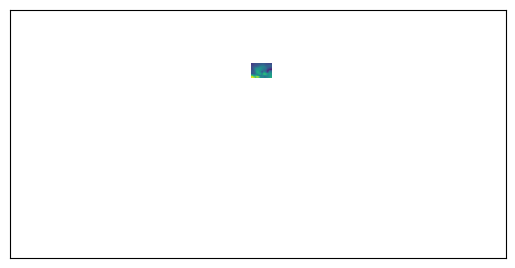

In [8]:
formatVpd = format_vpd(vpd, lon_grid, lat_grid, geo)

C:\Users\alexl\AppData\Local\Temp\ipykernel_1540\2998800598.py:11: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for temp_index, item in enumerate(contour.collections): #loop through contours


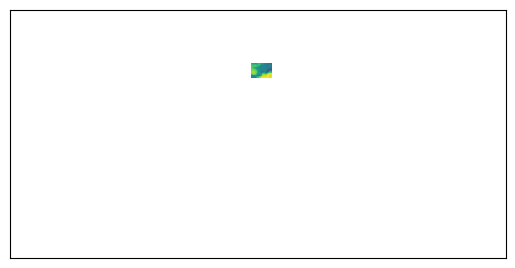

In [9]:
tempMean = format_data(tempMeanRaw, lon_grid, lat_grid, geo, value_name="TM")
tempMax = format_data(tempMaxRaw, lon_grid, lat_grid, geo, value_name="TX")
tempMin = format_data(tempMinRaw, lon_grid, lat_grid, geo, value_name="TN")

C:\Users\alexl\AppData\Local\Temp\ipykernel_1540\2998800598.py:11: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for temp_index, item in enumerate(contour.collections): #loop through contours


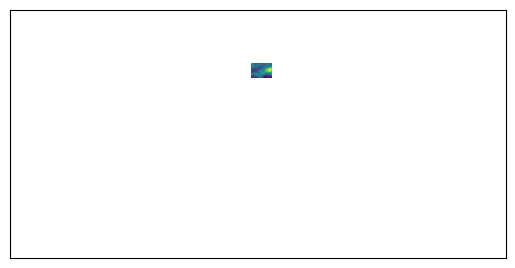

In [10]:
precipMean = format_data(precipMeanRaw, lon_grid, lat_grid, geo, value_name="RR", contourStep=5)

In [11]:
departements = { #set a dict of departement name as keys and dep code as value for missing dep values in datasets
    'Ain': 1,
    'Aisne': 2,
    'Allier': 3,
    'Alpes-de-Haute-Provence': 4,
    'Hautes-Alpes': 5,
    'Alpes-Maritimes': 6,
    'Ardèche': 7,
    'Ardennes': 8,
    'Ariège': 9,
    'Aube': 10,
    'Aude': 11,
    'Aveyron': 12,
    'Bouches-du-Rhône': 13,
    'Calvados': 14,
    'Cantal': 15,
    'Charente': 16,
    'Charente-Maritime': 17,
    'Cher': 18,
    'Corrèze': 19,
    'Corse': 20,
    "Côte-d'Or": 21,
    "Côtes-d'Armor": 22,
    'Creuse': 23,
    'Dordogne': 24,
    'Doubs': 25,
    'Drôme': 26,
    'Eure': 27,
    'Eure-et-Loir': 28,
    'Finistère': 29,
    'Gard': 30,
    'Haute-Garonne': 31,
    'Gers': 32,
    'Gironde': 33,
    'Hérault': 34,
    'Ille-et-Vilaine': 35,
    'Indre': 36,
    'Indre-et-Loire': 37,
    'Isère': 38,
    'Jura': 39,
    'Landes': 40,
    'Loir-et-Cher': 41,
    'Loire': 42,
    'Haute-Loire': 43,
    'Loire-Atlantique': 44,
    'Loiret': 45,
    'Lot': 46,
    'Lot-et-Garonne': 47,
    'Lozère': 48,
    'Maine-et-Loire': 49,
    'Manche': 50,
    'Marne': 51,
    'Haute-Marne': 52,
    'Mayenne': 53,
    'Meurthe-et-Moselle': 54,
    'Meuse': 55,
    'Morbihan': 56,
    'Moselle': 57,
    'Nièvre': 58,
    'Nord': 59,
    'Oise': 60,
    'Orne': 61,
    'Pas-de-Calais': 62,
    'Puy-de-Dôme': 63,
    'Pyrénées-Atlantiques': 64,
    'Hautes-Pyrénées': 65,
    'Pyrénées-Orientales': 66,
    'Bas-Rhin': 67,
    'Haut-Rhin': 68,
    'Rhône': 69,
    'Haute-Saône': 70,
    'Saône-et-Loire': 71,
    'Sarthe': 72,
    'Savoie': 73,
    'Haute-Savoie': 74,
    'Paris': 75,
    'Seine-Maritime': 76,
    'Seine-et-Marne': 77,
    'Yvelines': 78,
    'Deux-Sèvres': 79,
    'Somme': 80,
    'Tarn': 81,
    'Tarn-et-Garonne': 82,
    'Var': 83,
    'Vaucluse': 84,
    'Vendée': 85,
    'Vienne': 86,
    'Haute-Vienne': 87,
    'Vosges': 88,
    'Yonne': 89,
    'Territoire de Belfort': 90,
    'Essonne': 91,
    'Hauts-de-Seine': 92,
    'Seine-Saint-Denis': 93,
    'Val-de-Marne': 94,
    "Val-d'Oise": 95
}

In [12]:
precipMean = pd.DataFrame(precipMean)
precipMean['DEP'] = precipMean['Dep'].map(departements) #map dep name to dep code
precipMean = precipMean.drop("Dep", axis=1)

tempMean = pd.DataFrame(tempMean)
tempMean['DEP'] = tempMean['Dep'].map(departements) #map dep name to dep code
tempMean = tempMean.drop("Dep", axis=1)

tempMax = pd.DataFrame(tempMax)
tempMax['DEP'] = tempMax['Dep'].map(departements) #map dep name to dep code
tempMax = tempMax.drop("Dep", axis=1)

tempMin = pd.DataFrame(tempMin)
tempMin['DEP'] = tempMin['Dep'].map(departements) #map dep name to dep code
tempMin = tempMin.drop("Dep", axis=1)

formatVpd = pd.DataFrame(formatVpd)
formatVpd['DEP'] = formatVpd['Dep'].map(departements) #map dep name to dep code
formatVpd = formatVpd.drop("Dep", axis=1)

dfs = [precipMean, tempMean, tempMax, tempMin, formatVpd]
merged = reduce(lambda left, right: pd.merge(left, right, on=['DEP', 'MONTH']), dfs) #use reduce to merge df1 and df2, then the result with df3, then df4... until there is no more df in the dfs list

In [17]:
merged

,MONTH,RR,DEP,TM,TX,TN,vpd_max,vpd_min,vpd_mean
0,4,81.232589,1,8.104298,19.258594,-1.848504,0.345709,0.255709,0.300709
1,4,46.002930,2,8.845982,19.483982,-0.803804,0.345709,0.330709,0.338209
2,4,62.827392,3,9.371968,20.109698,-1.351845,0.345709,0.300709,0.321709
3,4,89.419619,4,5.659040,15.669755,-5.239765,0.345709,0.165709,0.255709
4,4,136.834148,5,5.129718,15.959362,-20.318850,0.300709,0.150709,0.220709
...,...,...,...,...,...,...,...,...,...
565,9,42.731328,91,16.182037,28.015409,6.870212,0.700772,0.640772,0.672915
566,9,43.555869,92,16.182037,27.370241,6.870212,0.655772,0.625772,0.640772
567,9,43.555869,93,16.182037,27.413952,6.870212,0.655772,0.625772,0.640772
568,9,43.555869,94,16.182037,28.015409,6.870212,0.670772,0.640772,0.655772


In [13]:
merged.to_csv("currentYear/weather_forecast.csv")

Text(0.5, 1.0, 'Dew 0.1°')

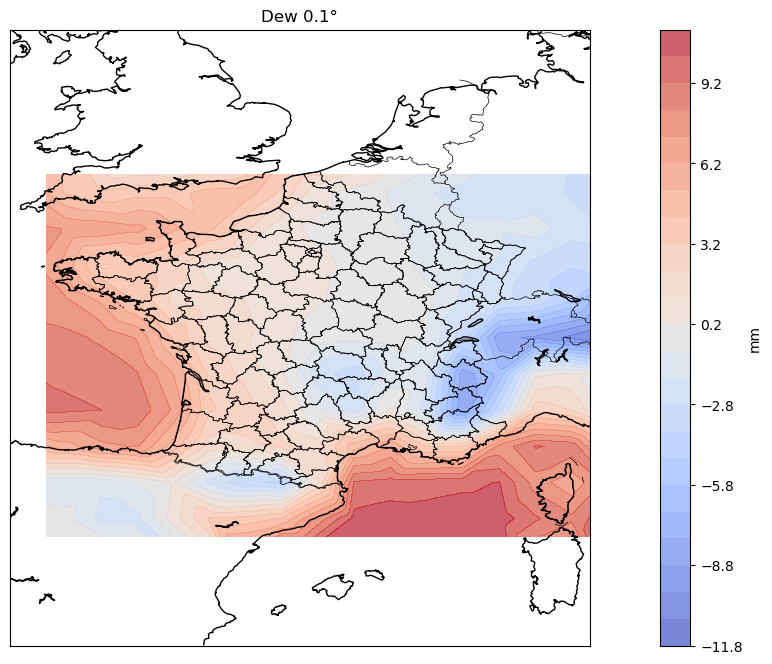

In [16]:
plt.figure(figsize=(18,8))
m = Basemap(projection='cyl', resolution='i',
            llcrnrlat=38,  urcrnrlat=55, llcrnrlon=-6, urcrnrlon=10)
m.readshapefile("shp/geojsonfrance_corse_20", 'franceDep', drawbounds=True)
m.drawcoastlines()
m.drawcountries()
temperature_range = np.arange(np.min(tempMinRaw[0] - 1), np.max(tempMinRaw[0] + 1), 1)
contour = m.contourf(lon_grid, lat_grid, tempMinRaw[0], levels=temperature_range, cmap='coolwarm', alpha=0.7)
cbar = plt.colorbar(contour, orientation='vertical', label="mm")
plt.title("Dew 0.1°")